<a href="https://colab.research.google.com/github/XuRui314/HITSZ_2022_NLP_Project/blob/main/Text_Classification_with_BERT_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with BERT in PyTorch
> The notebook is made from [Text Classification with BERT in PyTorch](https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f)

How to leverage a pre-trained BERT model from Hugging Face to classify text of news articles


## Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Thu Jun 16 04:12:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 8.7 MB/s 
     |████████████████████████████████| 596 kB 61.3 MB/s 
     |████████████████████████████████| 86 kB 5.6 MB/s 
     |████████████████████████████████| 6.6 MB 49.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
# 这个也是必须要做的，因为不check cuda的话可能会检测不到
import torch
print(torch.cuda.device_count())
print(torch.cuda.is_available())

1
True


In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun 16 04:12:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Introduction
![](https://miro.medium.com/max/875/1*Gzqs1XjVgH-URnan5kwQDg.jpeg)
Back in 2018, Google developed a powerful Transformer-based machine learning model for NLP applications that outperforms previous language models in different benchmark datasets. And this model is called BERT.

In this post, we’re going to use a pre-trained BERT model from Hugging Face for a text classification task. As you might already know, the main goal of the model in a text classification task is to categorize a text into one of the predefined labels or tags.
![](https://miro.medium.com/max/875/1*qzpJIgODil4oyh5e9BNOiQ.png)
Specifically, soon we’re going to use the pre-trained BERT model to classify whether the text of a news article can be categorized as sport, politics, business, entertainment, or tech category.

But before we dive into the implementation, let’s talk about the concept behind BERT briefly.

### **What is BERT?**

BERT is an acronym for Bidirectional Encoder Representations from Transformers. The name itself gives us several clues to what BERT is all about.

BERT architecture consists of several Transformer encoders stacked together. Each Transformer encoder encapsulates two sub-layers: a self-attention layer and a feed-forward layer.

There are two different BERT models:

1. BERT base, which is a BERT model consists of 12 layers of Transformer encoder, 12 attention heads, 768 hidden size, and 110M parameters.
2. BERT large, which is a BERT model consists of 24 layers of Transformer encoder,16 attention heads, 1024 hidden size, and 340 parameters.

![](https://miro.medium.com/max/875/1*4bet66zMfpkDaaOQdKF-mg.png)

There are at least two reasons why BERT is a powerful language model:

1. It is pre-trained on unlabeled data extracted from BooksCorpus, which has 800M words, and from Wikipedia, which has 2,500M words.
2. As the name suggests, it is pre-trained by utilizing the bidirectional nature of the encoder stacks. This means that BERT learns information from a sequence of words not only from left to right, but also from right to left.


### **BERT Input and Output**

BERT model expects a sequence of tokens (words) as an input. In each sequence of tokens, there arse two special tokens that BERT would expect as an input:

1. **[CLS]**: This is the first token of every sequence, which stands for classification token.
2. **[SEP]**: This is the token that makes BERT know which token belongs to which sequence. This special token is mainly important for a next sentence prediction task or question-answering task. If we only have one sequence, then this token will be appended to the end of the sequence.
To make it more clear, let’s say we have a text consisting of the following short sentence:

To make it more clear, let’s say we have a text consisting of the following short sentence:
![](https://miro.medium.com/max/693/1*p8lCLYbzfbcDnnnqUqRjKw.png)

As a first step, we need to transform this sentence into a sequence of tokens (words) and this process is called *tokenization*.

![](https://miro.medium.com/max/861/1*SQiPqx4z0Vuav71T6vwuNw.png)
Although we have tokenized our input sentence, we need to do one more step. We need to reformat that sequence of tokens by adding **[CLS]** and **[SEP]** tokens before using it as an input to our BERT model.
![](https://miro.medium.com/max/875/1*qkszUyGzFe-bHWdbbVfqiw.png)

Luckily, we only need one line of code to transform our input sentence into a sequence of tokens that BERT expects as we have seen above. We will use `BertTokenizer` to do this and you can see how we do this later on.

It is also important to note that the maximum size of tokens that can be fed into BERT model is 512. If the tokens in a sequence are less than 512, we can use padding to fill the unused token slots with **[PAD]** token. If the tokens in a sequence are longer than 512, then we need to do a truncation.

And that’s all that BERT expects as input.

BERT model then will output an embedding vector of size 768 in each of the tokens. We can use these vectors as an input for different kinds of NLP applications, whether it is text classification, next sentence prediction, Named-Entity-Recognition (NER), or question-answering.

For a text classification task, we focus our attention on the embedding vector output from the special **[CLS]** token. This means that we’re going to use the embedding vector of size 768 from **[CLS]** token as an input for our classifier, which then will output a vector of size the number of classes in our classification task. The reason why we choose **[CLS]** output vector as our output vector: [explanation](https://blog.csdn.net/pearl8899/article/details/119335858)

Below is the illustration of the input and output of the BERT model.
![](https://miro.medium.com/max/875/1*CUE12SdxQ31xhvsTAPsg8g.png)

## Text Classification with BERT

Now we’re going to jump into our main topic to classify text with BERT. In this post, we’re going to use the BBC News Classification dataset. If you want to follow along, you can download the dataset on Kaggle.

This dataset is already in CSV format and it has 2126 different texts, each labeled under one of 5 categories: entertainment, sport, tech, business, or politics.

Let’s take a look at what the dataset looks like.

In [6]:
import pandas as pd
datapath = 'drive/MyDrive/dataset/bbc-text.csv'
df = pd.read_csv(datapath)
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


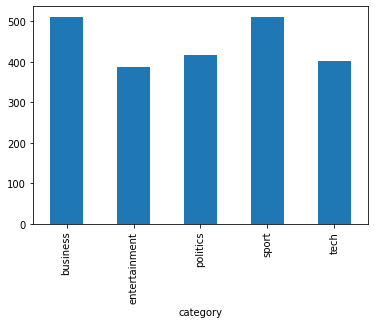

In [7]:
df.groupby(['category']).size().plot.bar()

As you can see, the dataframe only has two columns, which is *category* that will be our label, and text which will be our input data for BERT.

### **Preprocessing Data**

As you might already know from the previous section, we need to transform our text into the format that BERT expects by adding **[CLS]** and **[SEP]** tokens. We can do this easily with `BertTokenizer` class from Hugging Face.

To make it easier for us to understand the output that we get from `BertTokenizer`, let’s use a short text as an example.

In [8]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")

print(bert_input)
print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

{'input_ids': tensor([[  101,   146,  1209,  2824,  2508, 26173,  3568,   102,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])}
tensor([[  101,   146,  1209,  2824,  2508, 26173,  3568,   102,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


Here is the explanation of `BertTokenizer` parameters above:

- `padding` : to pad each sequence to the maximum length that you specify.
- `max_length` : the maximum length of each sequence. In this example we use 10, but for our actual dataset we will use 512, which is the maximum length of a sequence allowed for BERT.
- `truncation` : if True, then the tokens in each sequence that exceed the maximum length will be truncated.
- `return_tensors` : the type of tensors that will be returned. Since we’re using Pytorch, then we use pt. If you use Tensorflow, then you need to use tf .

The outputs that you see from `bert_input` variable above are necessary for our BERT model later on. But what do those outputs mean?

1. The first row is input_ids , which is the id representation of each token. We can actually decode these input ids into the actual tokens as follows:

In [9]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

[CLS] I will watch Memento tonight [SEP] [PAD] [PAD]


In [10]:
# tokens：[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]

# token_type_ids：0   0  0    0    0     0       0   0   1  1  1  1   1   1

As you can see, the `BertTokenizer` takes care of all of the necessary transformations of the input text such that it’s ready to be used as an input for our BERT model. It adds **[CLS]**, **[SEP]**, and **[PAD]** tokens automatically. Since we specified the maximum length to be 10, then there are only two **[PAD]** tokens at the end.

2. The second row is `token_type_ids` , which is a binary mask that identifies in which sequence a token belongs. If we only have a single sequence, then all of the token type ids will be 0. For a text classification task, token_type_ids is an optional input for our BERT model.


3. The third row is `attention_mask` , which is a binary mask that identifies whether a token is a real word or just padding. If the token contains **[CLS]**, **[SEP]**, or any real word, then the mask would be 1. Meanwhile, if the token is just padding or **[PAD]**, then the mask would be 0.

As you might notice, we use a pre-trained `BertTokenizer` from `bert-base-cased` model. This pre-trained tokenizer works well if the text in your dataset is in English.

If you have datasets from different languages, you might want to use `bert-base-multilingual-cased`. Specifically, if your dataset is in German, Dutch, Chinese, Japanese, or Finnish, you might want to use a tokenizer pre-trained specifically in these languages. You can check the name of the corresponding pre-trained tokenizer here.

To sum up, below is the illustration of what `BertTokenizer` does to our input sentence.
![](https://miro.medium.com/max/875/1*EZU3f1nSXhJ9Io0o2lOqow.png)

### Dataset Class
Now that we know what kind of output that we will get from `BertTokenizer` , let’s build a `Dataset` class for our news dataset that will serve as a class to generate our news data.



> some material about python inheritance: [here](https://blog.csdn.net/yilulvxing/article/details/85342114)

In [11]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In the above implementation, we define a variable called `labels` , which is a dictionary that maps the category in the dataframe into the id representation of our label. Notice that we also call `BertTokenizer` in the `__init__` function above to transform our input texts into the format that BERT expects.

After defining dataset class, let’s split our dataframe into training, validation, and test set with the proportion of 80:10:10.
Click here for explanation: [split 8:1:1](https://stackoverflow.com/a/38251213/17548344)



In [12]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])
print(len(df_train),len(df_val), len(df_test))
df_train.head()

1780 222 223


,category,text
414,politics,brown and blair face new rift claims for the u...
420,business,small firms hit by rising costs rising fuel ...
1644,entertainment,spirit awards hail sideways the comedy sideway...
416,tech,microsoft releases patches microsoft has warne...
1232,sport,arsenal through on penalties arsenal win 4-2 o...


### Model Building
So far, we have built a dataset class to generate our data. Now let’s build the actual model using a pre-trained BERT base model which has 12 layers of Transformer encoder.

If your dataset is not in English, it would be best if you use `bert-base-multilingual-cased` model. If your data is in German, Dutch, Chinese, Japanese, or Finnish, you can use the model pre-trained specifically in these languages. You can check the name of the corresponding pre-trained model [here](https://huggingface.co/transformers/pretrained_models.html).

In [13]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

As you can see from the code above, BERT model outputs two variables:

- The first variable, which we named `_` in the code above, contains the embedding vectors of all of the tokens in a sequence.
- The second variable, which we named `pooled_output`, contains the embedding vector of **[CLS]** token. For a text classification task, it is enough to use this embedding as an input for our classifier.

We then pass the `pooled_output` variable into a linear layer with ReLU activation function. At the end of the linear layer, we have a vector of size 5, each corresponds to a category of our labels (sport, business, politics, entertainment, and tech).

### Training Loop
Now it’s time for us to train the model. The training loop will be a standard PyTorch training loop.

In [14]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 890/890 [01:57<00:00,  7.59it/s]


Epochs: 1 | Train Loss:  0.765                 | Train Accuracy:  0.337                 | Val Loss:  0.633                 | Val Accuracy:  0.554


100%|██████████| 890/890 [01:57<00:00,  7.59it/s]


Epochs: 2 | Train Loss:  0.465                 | Train Accuracy:  0.760                 | Val Loss:  0.285                 | Val Accuracy:  0.941


100%|██████████| 890/890 [01:57<00:00,  7.60it/s]


Epochs: 3 | Train Loss:  0.210                 | Train Accuracy:  0.958                 | Val Loss:  0.143                 | Val Accuracy:  0.968


100%|██████████| 890/890 [01:57<00:00,  7.60it/s]


Epochs: 4 | Train Loss:  0.111                 | Train Accuracy:  0.981                 | Val Loss:  0.076                 | Val Accuracy:  0.986


100%|██████████| 890/890 [01:57<00:00,  7.56it/s]


Epochs: 5 | Train Loss:  0.068                 | Train Accuracy:  0.986                 | Val Loss:  0.053                 | Val Accuracy:  0.991


We train the model for 5 epochs and we use Adam as the optimizer, while the learning rate is set to 1e-6. We also need to use categorical cross entropy as our loss function since we’re dealing with multi-class classification.

It is recommended that you use GPU to train the model since BERT base model contains 110 million parameters.

Obviously you might not get similar loss and accuracy values as the screenshot above due to the randomness of training process. If you haven’t got a good result after 5 epochs, try to increase the epochs to, let’s say, 10 or adjust the learning rate.

### Evaluate Model on Test Data
Now that we have trained the model, we can use the test data to evaluate the model’s performance on unseen data. Below is the function to evaluate the performance of the model on the test set.

Supplement material: [DataLoader Dataset](https://zhongqiang.blog.csdn.net/article/details/105499476?spm=1001.2101.3001.6650.2&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-2-105499476-blog-79058479.pc_relevant_paycolumn_v3&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-2-105499476-blog-79058479.pc_relevant_paycolumn_v3&utm_relevant_index=5) and [collate_fn](https://blog.csdn.net/zsfcg/article/details/90441352?spm=1001.2101.3001.6650.4&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-4-90441352-blog-119654104.pc_relevant_antiscanv2&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-4-90441352-blog-119654104.pc_relevant_antiscanv2&utm_relevant_index=8)

![](https://img-blog.csdnimg.cn/20200415093005357.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3d1emhvbmdxaWFuZw==,size_1,color_FFFFFF,t_70#pic_center)

In [27]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    # print(test.texts) list of dicts

    '''
    [{'input_ids': tensor([[  101,  525...]]), 'token_type_ids': tensor([0,0...]]), 'attention_mask': tensor([[1,1...]]),}
      {'input_ids': tensor([[  101,  1207...]]), 'token_type_ids': tensor([0,0...]]), 'attention_mask': tensor([[1,1...]])},
      ...]
    '''


    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].squeeze(1).to(device)

              # print(test_input)
              '''
              {'input_ids': tensor([[[ 101, 1184, 3945,  ..., 4795,  118,  102]],

              [[ 101,  184,  173,  ..., 1120,  189,  102]]]), 'token_type_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0]],

              [[0, 0, 0,  ..., 0, 0, 0]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 1, 1, 1]],

              [[1, 1, 1,  ..., 1, 1, 1]]])}
              '''

              # print(test_input.input_ids.shape) torch.Size([2, 1, 512])

              input_id = test_input['input_ids'].squeeze(1).to(device) # sequeeze here to get right input dim

              # print(input_id.shape) torch.Size([2, 512])

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.982


After running the code above, I got the accuracy of 0.994 from the test data. The accuracy that you’ll get will obviously slightly differ from mine due to the randomness during the training process.



## Conclusion
Now you know the step on how we can leverage a pre-trained BERT model from Hugging Face for a text classification task. I hope this post helps you to get started with BERT.

One thing to remember is that we can use the embedding vectors from BERT to do not only a sentence or text classification task, but also the more advanced NLP applications such as question answering, next sentence prediction, or Named-Entity-Recognition (NER) tasks.